In [1]:
import pandas as pd
import os
os.chdir('/Users/markjos/projects/malachor5')
import numpy as np
from typing import Literal
from tqdm import tqdm
tqdm.pandas()
from glob import glob
import math
from string import punctuation
from random import shuffle

import sys
sys.path.append('scripts')
from eval import get_word_language
from longform import load_and_resample
import torchaudio
import torch
import json

from transformers import WhisperTokenizer

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
longform_csv_path = 'data/elicitation-wavs/autotranscribed/metadata.csv'
df = pd.read_csv(longform_csv_path, index_col=0, keep_default_na=False)
print(f"{df.shape=}")
df.head()

df.shape=(109393, 8)


,wav_path,tier_name,start,end,transcription,eaf_path,wav_source,sli_pred
0,,asr,30,1414,"Hello, hello, hello.",/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG
1,,asr,2106,4755,"Hello, hello, hello, hello, hello.",/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG
2,,asr,6240,8502,"Hello, hello. This shit.",/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG
3,,asr,8535,8569,...,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG
4,,asr,8721,11269,Hello. Hello. Hello.,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG


# Whisper output cleaning
Figure out what labels are excessive repetitions and exclude

## Hard-coded style

In [3]:
tokenizer = WhisperTokenizer.from_pretrained('openai/whisper-medium')
df['normalized']=df['transcription'].apply(tokenizer.normalize)
df['normalized']

0                              hello hello hello
1                  hello hello hello hello hello
2                          hello hello this shit
3                                              .
4                              hello hello hello
                         ...                    
767                                         okay
768                                         yeah
769    but this really studied with the question
770                                         okay
771             yes i am going to stop recording
Name: normalized, Length: 109393, dtype: object

In [78]:
df['basic_normalized']=df['transcription'].apply(tokenizer.basic_normalize)

In [4]:
df['transcription']=df['normalized']

In [5]:
eng_only = lambda s: all(get_word_language(word) == 'eng' for word in s.split())
df['eng_only'] = df['transcription'].apply(eng_only)
df['eng_only'].value_counts()

eng_only
True     80307
False    29086
Name: count, dtype: int64

In [6]:
# get number of words per sentence
# and number of times most common word repeats
df['num_words']=df['transcription'].str.split().apply(len)
def get_most_freq_word_count(s:str):
    words = s.split()
    words = [x.lower() for x in words]
    if len(words)==0:
        return 0
    return max([words.count(w) for w in words])
df['max_word_count'] = df['transcription'].apply(get_most_freq_word_count)

In [7]:
(df['max_word_count']<5).value_counts()

max_word_count
True     105200
False      4193
Name: count, dtype: int64

In [8]:
str_is_punct = lambda s: all(c in punctuation for c in s.strip())
df['is_punct'] = df['transcription'].apply(str_is_punct)
df['is_punct'].value_counts()

is_punct
False    104488
True       4905
Name: count, dtype: int64

In [89]:
sli_eng_mask = df['sli_pred']=='ENG'
discard_mask = (~sli_eng_mask | (~df['eng_only']) | (df['max_word_count']>=5) | (df['is_punct']))
discard_mask.value_counts()

False    75955
True     33438
Name: count, dtype: int64

### Save dataframe with metadata for English annotations

In [ ]:
snippet_metadata_path = '/Users/markjos/projects/malachor5/notebooks/longform_dataset/snippets_metadata.csv'
df.to_csv(snippet_metadata_path, index=False)

: 

In [100]:
df_valid=df[~discard_mask]
df_valid = df_valid.drop_duplicates('transcription')
df_valid.shape

(47326, 14)

## Entropy style

In [33]:
df['charlen'] = df['transcription'].str.len()
df['charlen']

0      21
1      35
2      25
4      21
6       6
       ..
765    19
767     6
768     6
769    43
770     6
Name: charlen, Length: 74315, dtype: int64

In [34]:
def entropy(string):
    """Calculates the Shannon entropy of a string."""

    # Get the probability of each character in the string
    prob = {}
    for c in string:
        if c not in prob:
            prob[c] = 0
        prob[c] += 1
    for c in prob:
        prob[c] /= len(string)

    # Calculate the entropy
    entropy = -sum(p * math.log2(p) for p in prob.values())

    return entropy
df['entropy']=df['transcription'].apply(entropy)
df['entropy'].describe()

count    74315.000000
mean         3.185645
std          0.710206
min          0.000000
25%          2.584963
50%          3.337175
75%          3.733661
max          4.430225
Name: entropy, dtype: float64

<Axes: >

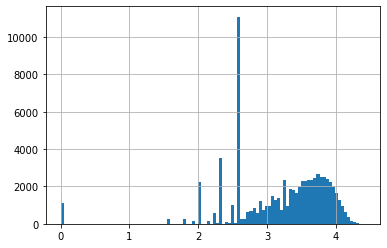

In [36]:
df['entropy'].hist(bins=100)

In [8]:
# df['count_most_frequent_word'].describe()

In [38]:
df['duration']=df['end']-df['start']
df[['duration', 'charlen', 'entropy']].corr()

,duration,charlen,entropy
duration,1.000000,0.788475,0.518018
charlen,0.788475,1.000000,0.692197
entropy,0.518018,0.692197,1.000000


In [39]:
df.loc[df['entropy']<2, 'transcription'].unique()

array([' Uh...', '', ' So...', ' Hmm.', ' See?', ' do do do.', ' m.',
       ' Um...', ' I.', ' We...', ' if', ' If...', ' goo goo.', ' uh...',
       ' SSA.', ' add', ' Hmm?', ' E.M.', ' Is...', ' L.A.', ' X.',
       ' See.', ' H.', ' G.', ' Z.', ' Is', ' A.', ' Q.', ' uh',
       ' la la.', ' Um', ' R. R. A.', ' J.', ' M O.', ' E.R.E.', ' H. R.',
       ' do', ' p', ' E.', ' R.E.', ' G. R.', ' W.', ' L.', ' La La.',
       ' d.', ' E. R.', ' egg.', ' L. A.', ' In', ' Z. A.', ' A B.',
       ' Oh', ' G.I.', ' or', ' in', ' shh.', 'lòlò lòlò', ' a',
       ' do do do do.', ' is', ' see.', ' I...', ' La La La.', ' to',
       ' d', ' R.', ' See I', ' ...so...', ' v.', ' V.', ' Boo.',
       ' is...', ' To...', ' N.', ' W. A.', ' ...Otto...', ' Or...',
       ' will', ' la la la.', ' ...for...', ' or...', ' GD...', ' V.P.',
       ' Nee.', ' h', ' ...age...', ' eye.', ' Y.', ' so', ' Hmm...',
       ' I. S.', ' re... re... re...', ' odd.', ' cool', ' F.', ' I. D.',
       ' s', ' um

In [40]:
df['charlen_nmzd'] = df['charlen'] / df['charlen'].max()
df['entropy_nmzd'] = df['entropy'] / df['entropy'].max()
df['entropy_over_charlen'] = df['entropy_nmzd'] / df['charlen_nmzd']
df['entropy_over_charlen'].describe()

count    73219.000000
mean        15.747412
std          9.860388
min          0.984865
25%          7.390085
50%         12.495746
75%         25.647680
max         36.133876
Name: entropy_over_charlen, dtype: float64

In [44]:
df.sort_values('entropy_over_charlen', ascending=True).iloc[-5:-1]['transcription'].to_list()

['', '', '', '']

In [48]:
cutoff_idx = 3_566
df_sorted=df.sort_values('entropy_over_charlen', ascending=True)
df_cutoff=df_sorted.iloc[cutoff_idx:]
df_cutoff.sort_values('charlen', ascending=False).head()['transcription'].to_list()

[" You could even type these, or I'll fix them afterwards, but I'll... copy link.",
 " Yeah, and Merrick does this as well. It's so confusing for English speakers.",
 " Okay, so let's break it down. Yeah, exactly. Yeah, I came to speak with you.",
 ' All right. I mean, maybe, maybe you could just keep screen sharing. So yeah.',
 " We're using this funny looking and same for like the this open. Oh, whoops."]

In [46]:
df_cutoff[['duration', 'charlen', 'entropy']].corr()

,duration,charlen,entropy
duration,1.000000,0.687693,0.496942
charlen,0.687693,1.000000,0.773562
entropy,0.496942,0.773562,1.000000


In [ ]:
is_punct = df_cutoff['transcription'].str.strip().apply(str_is_punct)
df_cutoff[is_punct].shape

In [91]:
# df_valid = df_cutoff[~is_punct].copy()
df_valid.shape[0], df.shape[0], df_valid.shape[0] / df.shape[0]

(75955, 109393, 0.6943314471675519)

In [17]:
df.sort_values('entropy_over_charlen').to_csv('data/elicitation-wavs/autotranscribed/metadata_sorted_by_entropy.csv', index=False)

In [92]:
df[df['sli_pred']=='TIC']

,wav_path,tier_name,start,end,transcription,eaf_path,wav_source,sli_pred,eng_only,num_words,max_word_count,is_punct,normalized,basic_normalized
213,,asr,902522,907804,apri vəlɛdɛ vəlɛdɛ javəlɛdɛ,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,False,4,2,False,apri vəlɛdɛ vəlɛdɛ javəlɛdɛ,apri vəlɛdɛ vəlɛdɛ javəlɛdɛ
402,,asr,1649663,1652329,da ɔɟɔ vəlɛdɛ unɛɾɛ,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,False,4,1,False,da ɔɟɔ vəlɛdɛ unɛɾɛ,da ɔɟɔ vəlɛdɛ unɛɾɛ
451,,asr,1807782,1809250,ndɔbagɛ,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,False,1,1,False,ndɔbagɛ,ndɔbagɛ
461,,asr,1858373,1859352,ndɔbagɛ,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,False,1,1,False,ndɔbagɛ,ndɔbagɛ
476,,asr,1920844,1922802,an ɔɟɔ kavəlɛdɔ ndɔbagɛ,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,False,4,1,False,an ɔɟɔ kavəlɛdɔ ndɔbagɛ,an ɔɟɔ kavəlɛdɔ ndɔbagɛ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,,asr,2278257,2280822,an ndɔn kaɾogɛ apri dɔndɔdɔ idɔtɔ ləvɔ kare,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,False,8,1,False,an ndɔn kaɾogɛ apri dɔndɔdɔ idɔtɔ ləvɔ kare,an ndɔn kaɾogɛ apri dɔndɔdɔ idɔtɔ ləvɔ kare
528,,asr,2331059,2332358,lagɛda ndɔdɔ tɛlubu,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,False,3,1,False,lagɛda ndɔdɔ tɛlubu,lagɛda ndɔdɔ tɛlubu
567,,asr,2469434,2470682,dɛbulti,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,False,1,1,False,dɛbulti,dɛbulti
575,,asr,2498762,2500804,dəvəɽa dɛr ive,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,TIC,False,3,1,False,dəvəɽa dɛr ive,dəvəɽa dɛr ive


In [115]:
asr_csv_path = 'data/hf-datasets/tira-clean/metadata.csv'
asr_df = pd.read_csv(asr_csv_path, index_col=0, keep_default_na=False)
asr_df=asr_df.reset_index(names='asr_index')
asr_df['tier_name']='human_label'
asr_df['eaf_path']=asr_df['eaf_source']
asr_df['sli_pred']=np.nan
asr_df=asr_df[asr_df['split']=='train']

df_valid['asr_index']=np.nan
df_valid['split']=np.nan

merge_cols = [
    'tier_name', 'start', 'end',
    'transcription', 'eaf_path',
    'wav_source', 'sli_pred',
    'asr_index', 'split',
]

merged_df = pd.concat([df_valid[merge_cols], asr_df[merge_cols]], ignore_index=True)
print(merged_df.shape)
merged_df.head()

(63710, 9)


,tier_name,start,end,transcription,eaf_path,wav_source,sli_pred,asr_index,split
0,asr,30.0,1414.0,hello hello hello,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG,NaN,NaN
1,asr,6240.0,8502.0,hello hello this shit,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG,NaN,NaN
2,asr,11387.0,13244.0,i do not know,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG,NaN,NaN
3,asr,13649.0,13986.0,yeah,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG,NaN,NaN
4,asr,26625.0,27064.0,thank you,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG,NaN,NaN


In [94]:
merged_df[merged_df['tier_name']=='human_label']

,tier_name,start,end,transcription,eaf_path,wav_source,sli_pred,asr_index,split
75955,human_label,2497647.0,2498747.0,lə̀və̀lɛ̀ðɛ́l únɛ̀ɾɛ̀,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,0.0,train
75956,human_label,2325216.0,2326306.0,kə̀ŋàcîí,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,1.0,test
75957,human_label,354974.0,356382.0,ŋ̀gátɛ́və́lɛ̂ðɔ́ nd̪ɔ̀bàgɛ̀,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,2.0,train
75958,human_label,154905.0,157215.0,ŋɔ́ðɔ́ ŋá və́lɛ̀ðà ðàŋàlà nd̪ɔ̀bà,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,3.0,train
75959,human_label,2311065.0,2312385.0,ðə̀və̀lèðɔ̀ŋ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,4.0,train
...,...,...,...,...,...,...,...,...,...
96430,human_label,1005320.0,1007400.0,ðá nɛ́lê və̀lɛ̀ðɔ́ nd̪ɔ̀bà,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,20475.0,train
96431,human_label,997005.0,997694.0,ŋə̀vrà,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,20476.0,test
96432,human_label,1121405.0,1122391.0,ŋə̀búrŋɛ̀ ánó,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,20477.0,train
96433,human_label,1050093.0,1051320.0,lá vŕðìt̪ɔ̀ kukuŋu ðɛdɔɽɔ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,NaN,20478.0,train


In [116]:
merged_df['filestem']=merged_df['eaf_path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
merged_df['filestem']

0        HH01082021
1        HH01082021
2        HH01082021
3        HH01082021
4        HH01082021
            ...    
63705    HH20230724
63706    HH20230516
63707    HH20230626
63708    HH20240308
63709    HH20210707
Name: filestem, Length: 63710, dtype: object

# Make language-balanced splits
- Take 2/3 of Tira ASR train data for Tira
- Make English dataset of same size
- Take remaining 1/3 of Tira ASR dataset and concat English to be same size

In [117]:
balance_df=merged_df.copy()
balance_df=balance_df[balance_df['filestem']!='HH20210312']
balance_df.shape

(63480, 10)

In [131]:
# keep lists of indices for each data partition
tira_mono_indices = []
eng_mono_indices = []
tira_cs_indices = []
tira_cs_indices_20_80_small = []
eng_cs_indices_50_50 = []
eng_cs_indices_80_20_small = []
eng_cs_indices_80_20_large = []
get_all_groups = lambda : tira_mono_indices + eng_mono_indices + tira_cs_indices + tira_cs_indices_20_80_small + eng_cs_indices_50_50 + eng_cs_indices_80_20_small + eng_cs_indices_80_20_large

In [185]:
get_split_duration = lambda df, idcs: df.loc[idcs, 'duration'].sum()

### Split Tira btw mono and CS

In [133]:
tira_mono_indices = []
tira_cs_indices = []
tira_asr_train_idcs = balance_df[
    (balance_df['tier_name']=='human_label')&
    (balance_df['split']=='train')
].index
# randomly sample 2/3 for Tira lang dataset
# initialize w/ Tira samples from recordings w/ no attested English
no_eng_files=[]
for filestem in balance_df['filestem'].unique():
    filestem_mask = balance_df['filestem']==filestem
    eng_mask = balance_df['sli_pred']=='ENG'
    if (filestem_mask&eng_mask).sum()==0:
        no_eng_files.append(filestem)
tira_mono_indices.extend(balance_df.loc[balance_df['filestem'].isin(no_eng_files)].index.tolist())

balance_df['duration']=balance_df['end']-balance_df['start']
tira_total_duration = balance_df.loc[tira_asr_train_idcs, 'duration'].sum()
print(f"{tira_total_duration/(60_000)=}")
tira_split_duration = get_split_duration(balance_df, tira_mono_indices)
i=0
while tira_split_duration < tira_total_duration*2/3:
    if i%1000==0:
        print(f"{tira_split_duration/60_000=}")
    idx = np.random.choice(tira_asr_train_idcs[~tira_asr_train_idcs.isin(tira_mono_indices)])
    tira_mono_indices.append(idx)
    tira_split_duration = get_split_duration(balance_df, tira_mono_indices)
    i+=1
tira_cs_indices.extend(balance_df[
    (balance_df['tier_name']=='human_label')&
    (~balance_df.index.isin(tira_mono_indices))
].index)
print(f"{len(tira_mono_indices)=}, {len(tira_cs_indices)=}")
balance_df.loc[tira_mono_indices, 'lang_balanced_dataset']='tira_mono'
balance_df.loc[tira_cs_indices, 'lang_balanced_dataset']='cs'
balance_df.pivot_table(index='lang_balanced_dataset', values='duration', aggfunc='sum', fill_value=0)/3_600_000

tira_total_duration/(60_000)=561.7255333333334
tira_split_duration/60_000=6.3005
tira_split_duration/60_000=41.854016666666666
tira_split_duration/60_000=76.3835
tira_split_duration/60_000=111.21041666666666
tira_split_duration/60_000=146.20178333333334
tira_split_duration/60_000=180.37508333333332
tira_split_duration/60_000=214.38485
tira_split_duration/60_000=249.57761666666667
tira_split_duration/60_000=284.3081833333333
tira_split_duration/60_000=319.1791166666667
tira_split_duration/60_000=354.62655
len(tira_mono_indices)=10728, len(tira_cs_indices)=5426


,duration
lang_balanced_dataset,
cs,3.120263
tira_mono,6.241829


In [167]:
with open('notebooks/longform_dataset/tira_mono_indices.txt', 'w') as f:
    f.write('\n'.join(map(str, tira_mono_indices)))
with open('notebooks/longform_dataset/tira_cs_indices.txt', 'w') as f:
    f.write('\n'.join(map(str, tira_cs_indices)))

In [134]:
def get_nearest_eng_row(df, idx):
    asr_row = df.loc[idx]
    filestem_mask = df['filestem']==asr_row['filestem']
    eng_mask = df['sli_pred']=='ENG'
    ungrouped_mask = ~df.index.isin(get_all_groups())
    eng_rows = df[filestem_mask&eng_mask&ungrouped_mask]
    if eng_rows.shape[0]==0:
        # print(asr_row['filestem'], end=', ')
        # print(f"{filestem_mask.sum()=}")
        # print(f"{ungrouped_mask.sum()=}")
        # print(f"{(filestem_mask&ungrouped_mask).sum()=}")
        # print(f"{(eng_mask&ungrouped_mask).sum()=}")
        # print(f"{(filestem_mask&eng_mask).sum()=}")
        # print(asr_row)
        return
    eng_row = eng_rows.iloc[
        (eng_rows['start']-asr_row['start']).abs().argsort().iloc[0]
    ]
    return eng_row

### Get English records for 50/50 Tira/Eng split

In [160]:
eng_cs_indices_50_50 = []
asr_idx2cs50_50_idcs = {balance_df.at[idx, 'asr_index']:[idx] for idx in tira_cs_indices}
balance_df.loc[(balance_df['tier_name']=='asr'), 'asr_index'] = np.nan

tira_cs_duration = get_split_duration(balance_df, tira_cs_indices)
eng_cs_duration = get_split_duration(balance_df, eng_cs_indices_50_50)
i=-1
nonadjacent_add_ct=0
looped_once = False
while (not looped_once) or (eng_cs_duration < tira_cs_duration):
    i+=1
    if i==len(tira_cs_indices):
        print("Looped through dataset, returning to start...")
        looped_once = True
        if (eng_cs_duration >= tira_cs_duration):
            break
        i=0    
    if i%1_000==0:
        print(f"{eng_cs_duration=}, {tira_cs_duration=}, {eng_cs_duration/tira_cs_duration=}")

    idx = tira_cs_indices[i]
    eng_row = get_nearest_eng_row(balance_df, idx)
    if eng_row is None:
        eng_mask = balance_df['sli_pred']=='ENG'
        ungrouped_mask = ~balance_df.index.isin(get_all_groups())
        # eng_row_idx = np.random.choice(balance_df[eng_mask&ungrouped_mask].index)
        eng_row_idx = balance_df[eng_mask&ungrouped_mask].sort_values('duration').iloc[0].name
        eng_row = balance_df.loc[eng_row_idx]
        nonadjacent_add_ct+=1
    eng_cs_indices_50_50.append(eng_row.name)
    asr_index=balance_df.at[idx, 'asr_index']
    asr_idx2cs50_50_idcs[asr_index].append(eng_row.name)
    eng_cs_duration = get_split_duration(balance_df, eng_cs_indices_50_50)

print(f"{nonadjacent_add_ct=}")


eng_cs_duration=0.0, tira_cs_duration=11232946.0, eng_cs_duration/tira_cs_duration=0.0
eng_cs_duration=2191133.0, tira_cs_duration=11232946.0, eng_cs_duration/tira_cs_duration=0.1950630760621479
eng_cs_duration=4430978.0, tira_cs_duration=11232946.0, eng_cs_duration/tira_cs_duration=0.3944626814728745
eng_cs_duration=6821561.0, tira_cs_duration=11232946.0, eng_cs_duration/tira_cs_duration=0.6072815626461661
eng_cs_duration=9314611.0, tira_cs_duration=11232946.0, eng_cs_duration/tira_cs_duration=0.829222449747377
eng_cs_duration=11860672.0, tira_cs_duration=11232946.0, eng_cs_duration/tira_cs_duration=1.0558825796901365
Looped through dataset, returning to start...
nonadjacent_add_ct=471


In [161]:
balance_df.loc[eng_cs_indices_50_50+tira_cs_indices].pivot_table(index='tier_name', values='duration', aggfunc='sum', fill_value=0)/3_600_000

,duration
tier_name,
asr,3.600599
human_label,3.120263


In [164]:
sum(len(v) for v in asr_idx2cs50_50_idcs.values())/len(asr_idx2cs50_50_idcs)

2.0

In [181]:
with open('notebooks/longform_dataset/eng_cs_indices_50_50.txt', 'w') as f:
    f.write('\n'.join(map(str, eng_cs_indices_50_50)))

def prepare_for_json(d):
    converted_keys = {int(k):v for k,v in d.items()}
    converted_vals = {k:[int(x) for x in v] for k,v in converted_keys.items()}
    return converted_vals
with open('notebooks/longform_dataset/asr_idx2cs50_50_idcs.json', 'w') as f:
    json.dump(prepare_for_json(asr_idx2cs50_50_idcs), f)

### Get English records for 20/80 big split

In [193]:
eng_cs_indices_80_20_large = []
asr_idx2cs20_80_large_idcs = {balance_df.at[idx, 'asr_index']:[idx] for idx in tira_cs_indices}

tira_cs_duration = get_split_duration(balance_df, tira_cs_indices)
eng_cs_duration = get_split_duration(balance_df, eng_cs_indices_80_20_large)
i=-1
nonadjacent_add_ct=0
looped_once = False
while (not looped_once) or (eng_cs_duration < tira_cs_duration*4):
    i+=1
    if i==len(tira_cs_indices):
        print("Looped through dataset, returning to start...")
        looped_once = True
        i=0    
    if i%1_000==0:
        print(f"{eng_cs_duration=}, {tira_cs_duration=}, {eng_cs_duration/tira_cs_duration=}")

    idx = tira_cs_indices[i]
    eng_row = get_nearest_eng_row(balance_df, idx)
    if eng_row is None:
        eng_mask = balance_df['sli_pred']=='ENG'
        ungrouped_mask = ~balance_df.index.isin(eng_cs_indices_80_20_large)
        eng_row_idx = np.random.choice(balance_df[eng_mask&ungrouped_mask].index)
        # eng_row_idx = balance_df[eng_mask&ungrouped_mask].sort_values('duration').iloc[0].name
        eng_row = balance_df.loc[eng_row_idx]
        nonadjacent_add_ct+=1
    eng_cs_indices_80_20_large.append(eng_row.name)
    asr_index=balance_df.at[idx, 'asr_index']
    asr_idx2cs20_80_large_idcs[asr_index].append(eng_row.name)
    eng_cs_duration = get_split_duration(balance_df, eng_cs_indices_80_20_large)
print(f"{nonadjacent_add_ct=}")

eng_cs_duration=0.0, tira_cs_duration=11232946.0, eng_cs_duration/tira_cs_duration=0.0
eng_cs_duration=2779019.0, tira_cs_duration=11232946.0, eng_cs_duration/tira_cs_duration=0.24739894592211162
eng_cs_duration=5707132.0, tira_cs_duration=11232946.0, eng_cs_duration/tira_cs_duration=0.5080708124119888
eng_cs_duration=8438281.0, tira_cs_duration=11232946.0, eng_cs_duration/tira_cs_duration=0.7512081870597437
eng_cs_duration=11328412.0, tira_cs_duration=11232946.0, eng_cs_duration/tira_cs_duration=1.0084987500162468
eng_cs_duration=14110802.0, tira_cs_duration=11232946.0, eng_cs_duration/tira_cs_duration=1.25619779530677
Looped through dataset, returning to start...
eng_cs_duration=15369420.0, tira_cs_duration=11232946.0, eng_cs_duration/tira_cs_duration=1.368244804168025
eng_cs_duration=18092992.0, tira_cs_duration=11232946.0, eng_cs_duration/tira_cs_duration=1.610707645171623
eng_cs_duration=20976328.0, tira_cs_duration=11232946.0, eng_cs_duration/tira_cs_duration=1.8673932911277238
e

In [194]:
balance_df.loc[eng_cs_indices_80_20_large+tira_cs_indices].pivot_table(index='tier_name', values='duration', aggfunc='sum', fill_value=0)/3_600_000

,duration
tier_name,
asr,12.481507
human_label,3.120263


In [198]:
with open('notebooks/longform_dataset/eng_cs_indices_80_20_large.txt', 'w') as f:
    f.write('\n'.join(map(str, eng_cs_indices_80_20_large)))
with open('notebooks/longform_dataset/asr_idx2cs20_80_large_idcs.json', 'w') as f:
    json.dump(prepare_for_json(asr_idx2cs20_80_large_idcs), f)

In [197]:
sum(len(v) for v in asr_idx2cs20_80_large_idcs.values())/len(asr_idx2cs20_80_large_idcs)

3.9799115370438627

### Get Tira records for 20/80 small split

In [209]:
tira_cs_indices_20_80_small = []
valid_idcs = tira_cs_indices.copy()
shuffle(valid_idcs)

tira_mono_duration = get_split_duration(balance_df, tira_mono_indices)
while get_split_duration(balance_df, tira_cs_indices_20_80_small) < tira_mono_duration*0.2:
    idx = valid_idcs.pop()
    tira_cs_indices_20_80_small.append(idx)
print(f"{len(tira_cs_indices_20_80_small)=}")

len(tira_cs_indices_20_80_small)=2154


In [210]:
with open('notebooks/longform_dataset/tira_cs_indices_20_80_small.txt', 'w') as f:
    f.write('\n'.join(map(str, tira_cs_indices_20_80_small)))

### Get English records for 20/80 small split

In [214]:
eng_cs_indices_80_20_small = []
asr_idx2cs20_80_small_idcs = {balance_df.at[idx, 'asr_index']:[idx] for idx in tira_cs_indices_20_80_small}

tira_cs_duration = get_split_duration(balance_df, tira_cs_indices_20_80_small)
eng_cs_duration = get_split_duration(balance_df, eng_cs_indices_80_20_small)
i=-1
nonadjacent_add_ct=0
looped_once = False
while (not looped_once) or (eng_cs_duration < tira_cs_duration*4):
    i+=1
    if i==len(tira_cs_indices_20_80_small):
        print("Looped through dataset, returning to start...")
        looped_once = True
        i=0    
    if i%1_000==0:
        print(f"{eng_cs_duration=}, {tira_cs_duration=}, {eng_cs_duration/tira_cs_duration=}")

    idx = tira_cs_indices_20_80_small[i]
    eng_row = get_nearest_eng_row(balance_df, idx)
    if eng_row is None:
        eng_mask = balance_df['sli_pred']=='ENG'
        ungrouped_mask = ~balance_df.index.isin(eng_cs_indices_80_20_small)
        eng_row_idx = np.random.choice(balance_df[eng_mask&ungrouped_mask].index)
        # eng_row_idx = balance_df[eng_mask&ungrouped_mask].sort_values('duration').iloc[0].name
        eng_row = balance_df.loc[eng_row_idx]
        nonadjacent_add_ct+=1
    eng_cs_indices_80_20_small.append(eng_row.name)
    asr_index=balance_df.at[idx, 'asr_index']
    asr_idx2cs20_80_small_idcs[asr_index].append(eng_row.name)
    eng_cs_duration = get_split_duration(balance_df, eng_cs_indices_80_20_small)
print(f"{nonadjacent_add_ct=}")

eng_cs_duration=0.0, tira_cs_duration=4494261.0, eng_cs_duration/tira_cs_duration=0.0
eng_cs_duration=2726570.0, tira_cs_duration=4494261.0, eng_cs_duration/tira_cs_duration=0.6066781613261891
eng_cs_duration=5436288.0, tira_cs_duration=4494261.0, eng_cs_duration/tira_cs_duration=1.2096066516831132
Looped through dataset, returning to start...
eng_cs_duration=5844072.0, tira_cs_duration=4494261.0, eng_cs_duration/tira_cs_duration=1.300341034933218
eng_cs_duration=8606616.0, tira_cs_duration=4494261.0, eng_cs_duration/tira_cs_duration=1.9150236267987106
eng_cs_duration=11437238.0, tira_cs_duration=4494261.0, eng_cs_duration/tira_cs_duration=2.544853981555588
Looped through dataset, returning to start...
eng_cs_duration=11846520.0, tira_cs_duration=4494261.0, eng_cs_duration/tira_cs_duration=2.6359216787810054
eng_cs_duration=14557304.0, tira_cs_duration=4494261.0, eng_cs_duration/tira_cs_duration=3.2390873605249006
eng_cs_duration=17211749.0, tira_cs_duration=4494261.0, eng_cs_duration/

In [215]:
balance_df.loc[eng_cs_indices_80_20_small+tira_cs_indices_20_80_small].pivot_table(index='tier_name', values='duration', aggfunc='sum', fill_value=0)/3_600_000

,duration
tier_name,
asr,4.993824
human_label,1.248406


In [216]:
sum(len(v) for v in asr_idx2cs20_80_small_idcs.values())/len(asr_idx2cs20_80_small_idcs)

4.058960074280408

In [217]:
with open('notebooks/longform_dataset/eng_cs_indices_80_20_small.txt', 'w') as f:
    f.write('\n'.join(map(str, eng_cs_indices_80_20_small)))

with open('notebooks/longform_dataset/asr_idx2cs20_80_small_idcs.json', 'w') as f:
    json.dump(prepare_for_json(asr_idx2cs20_80_small_idcs), f)

In [218]:
get_split_duration(balance_df, get_all_groups())/3_600_000

31.68642861111111

### Get English records for English monolingual partition

In [219]:
eng_mono_indices = []
valid_idcs = balance_df[
    (balance_df['sli_pred']=='ENG')&
    (~balance_df.index.isin(get_all_groups()))
].index.to_list()
shuffle(valid_idcs)
while get_split_duration(balance_df, eng_mono_indices) < tira_mono_duration:
    idx = valid_idcs.pop()
    eng_mono_indices.append(idx)
print(f"{len(eng_mono_indices)=}")

len(eng_mono_indices)=8592


In [220]:
with open('notebooks/longform_dataset/eng_mono_indices.txt', 'w') as f:
    f.write('\n'.join(map(str, eng_mono_indices)))

In [231]:
balance_df_path = 'notebooks/longform_dataset/balance_df.csv'

# What does normalization do to Tira text?

In [227]:
tira_transcriptions = balance_df.loc[tira_mono_indices, 'transcription'].to_list()
nmzd=[tokenizer.normalize(t) for t in tira_transcriptions]
bsc_nmzd=[tokenizer.basic_normalize(t) for t in tira_transcriptions]

In [228]:
nmz_df = pd.DataFrame({'transcription':tira_transcriptions, 'normalized':nmzd, 'basic_normalized':bsc_nmzd})
nmz_df.head()

,transcription,normalized,basic_normalized
0,ìŋgádɔ̀ ɔ́ɾɛ́,iŋgadɔ ɔɾɛ,ìŋgádɔ ɔ ɾɛ
1,kàðɛ́və̀lèðɔ́,kadɛvəledɔ,kàðɛ və lèðɔ
2,ŋàðɛ́ úrnɔ̀ və̀lèðɔ́ t̪àwə̀nì,ŋadɛ urnɔ vəledɔ tawəni,ŋàðɛ úrnɔ və lèðɔ t àwə nì
3,ŋàðɛ́ úrnɔ̀ və̀lèðà,ŋadɛ urnɔ vəleda,ŋàðɛ úrnɔ və lèðà
4,kàðɛ́və̀lèðà ŋìnɛ̀,kadɛvəleda ŋinɛ,kàðɛ və lèðà ŋìnɛ


In [222]:
balance_df.index.name='index'
balance_df.to_csv(balance_df_path)

# Make text files for training LM

In [232]:
balance_df=pd.read_csv(balance_df_path, index_col='index')
balance_df.head()

,Unnamed: 0,tier_name,start,end,transcription,eaf_path,wav_source,sli_pred,asr_index,split,filestem,duration,lang_balanced_dataset,label_path,clip_name
index,,,,,,,,,,,,,,,
0,0,asr,30.0,1414.0,hello hello hello,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG,NaN,NaN,HH01082021,1384.0,NaN,data/elicitation-wavs/wav/labels/0.txt,data/elicitation-wavs/wav/clips/0.wav
1,1,asr,6240.0,8502.0,hello hello this shit,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG,NaN,NaN,HH01082021,2262.0,NaN,data/elicitation-wavs/wav/labels/1.txt,data/elicitation-wavs/wav/clips/1.wav
2,2,asr,11387.0,13244.0,i do not know,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG,NaN,NaN,HH01082021,1857.0,NaN,data/elicitation-wavs/wav/labels/2.txt,data/elicitation-wavs/wav/clips/2.wav
3,3,asr,13649.0,13986.0,yeah,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG,NaN,NaN,HH01082021,337.0,NaN,data/elicitation-wavs/wav/labels/3.txt,data/elicitation-wavs/wav/clips/3.wav
4,4,asr,26625.0,27064.0,thank you,/home/AD/mjsimmons/datasets/elicitation-wavs/a...,/home/AD/mjsimmons/datasets/elicitation-wavs/m...,ENG,NaN,NaN,HH01082021,439.0,NaN,data/elicitation-wavs/wav/labels/4.txt,data/elicitation-wavs/wav/clips/4.wav


In [245]:
unique_sent=balance_df.loc[balance_df['sli_pred']=='ENG', 'transcription'].unique()
tokenizer = WhisperTokenizer.from_pretrained('openai/whisper-tiny')
token_lists=[
    tokenizer.encode(sentence, add_special_tokens=False) for sentence in tqdm(unique_sent)
]
token_sents = [' '.join(str(t) for t in sent)+'\n' for sent in tqdm(token_lists)]
token_sents[:5]

100%|██████████| 47326/47326 [00:00<00:00, 374068.84it/s]


['675 1913 7751 7751\n',
 '675 1913 7751 341 4611\n',
 '72 360 406 458\n',
 '19650\n',
 '40683 291\n']

In [246]:
with open('/Users/markjos/projects/malachor5/data/hf-datasets/eng_mono/eng_tkzd.txt', 'w') as f:
    f.writelines(token_sents)

# Old stuff

In [ ]:
ms_to_frames = lambda ms: int(ms*16)

elicitation_wav_dir = 'data/elicitation-wavs/wav'
tira_cs_dir = 'data/hf-datasets/tira_cs_balanced'
os.makedirs(os.path.join(tira_cs_dir, 'train'), exist_ok=True)

def snip_record(row):
    wav_path = os.path.join(
        elicitation_wav_dir,
        os.path.basename(row['wav_source'])
    )
    wav = load_and_resample(wav_path)
    start_frame = ms_to_frames(row['start'])
    end_frame = ms_to_frames(row['end'])
    snip = wav[start_frame:end_frame]
    del wav
    return snip

def concat_recordings_and_save(rows, i):
    clip_basename = str(i)+'.wav'
    clip_relpath = os.path.join('train', clip_basename)
    clip_path = os.path.join(tira_cs_dir, clip_relpath)
    snips = rows.apply(snip_record, axis=1).tolist()
    torchaudio.save(clip_path, torch.concatenate(snips), 16_000)
    return clip_relpath

def make_cs_labels(df):
    cs_labels = []
    for i in tqdm(df['asr_index'].unique().tolist()):
        if np.isnan(i):
            continue
        i=int(i)
        has_index = df['asr_index']==i
        min_start = df[has_index]['start'].min()
        max_end = df[has_index]['end'].max()
        transcription = ' '.join([
            s.strip() for s in df[has_index].sort_values('start')['transcription']
        ]).strip()
        filestem = df[has_index]['filestem'].unique()
        clip_relpath = concat_recordings_and_save(df[has_index], i)
        cs_labels.append({
            'asr_index': i,
            'start': min_start,
            'end': max_end,
            'transcription': transcription,
            'indices': df[has_index].sort_values('start').index.tolist(),
            'duration': max_end-min_start,
            'split': 'train',
            'filestem': filestem,
            'file_name': clip_relpath,
        })
    return pd.DataFrame(cs_labels)

In [ ]:
make_cs_labels(balance_df)

In [224]:
balance_df.pivot_table(index='lang_balanced_dataset', values='duration', aggfunc='sum', fill_value=0)

,duration
lang_balanced_dataset,
cs,22444567.0
tira_mono,22470586.0


In [38]:
balance_df.loc[
    ~balance_df['lang_balanced_dataset'].isin(['cs', 'tira']),
    'lang_balanced_dataset'
]=np.nan
# randomly sample 2/3 for Tira lang dataset
# initialize w/ Tira samples from recordings w/ no attested English

tira_split_duration = get_tira_split_duration(balance_df)
eng_split_duration = get_eng_split_duration(balance_df)
eng_mask = balance_df['sli_pred']=='ENG'
i=0
while eng_split_duration < tira_split_duration:
    if i%1000==0:
        print(f"{eng_split_duration=} {tira_split_duration=} {eng_split_duration/tira_split_duration=}")
    ungrouped_mask = balance_df['lang_balanced_dataset'].isna()
    idx = np.random.choice(
        balance_df[ungrouped_mask&eng_mask].index
    )
    # skip recordings with just one word
    if len(balance_df.loc[idx, 'transcription'].split())<=1:
        continue
    balance_df.loc[idx, 'lang_balanced_dataset']='eng'
    balance_df.loc[idx, 'split']='train'
    eng_split_duration = get_eng_split_duration(balance_df)
    i+=1
print(balance_df['lang_balanced_dataset'].value_counts())
balance_df.pivot_table(index='lang_balanced_dataset', values='duration', aggfunc='sum', fill_value=0)

eng_split_duration=0.0 tira_split_duration=22469100.0 eng_split_duration/tira_split_duration=0.0
eng_split_duration=2789629.0 tira_split_duration=22469100.0 eng_split_duration/tira_split_duration=0.12415401595969576
eng_split_duration=5552224.0 tira_split_duration=22469100.0 eng_split_duration/tira_split_duration=0.2471048684638014
eng_split_duration=5552224.0 tira_split_duration=22469100.0 eng_split_duration/tira_split_duration=0.2471048684638014
eng_split_duration=5552224.0 tira_split_duration=22469100.0 eng_split_duration/tira_split_duration=0.2471048684638014
eng_split_duration=5552224.0 tira_split_duration=22469100.0 eng_split_duration/tira_split_duration=0.2471048684638014
eng_split_duration=8267010.0 tira_split_duration=22469100.0 eng_split_duration/tira_split_duration=0.36792795439069653
eng_split_duration=8267010.0 tira_split_duration=22469100.0 eng_split_duration/tira_split_duration=0.36792795439069653
eng_split_duration=11049665.0 tira_split_duration=22469100.0 eng_split_dur

,duration
lang_balanced_dataset,
cs,22593688.0
eng,22469248.0
tira,22469100.0


In [39]:
balance_df.pivot_table(index='lang_balanced_dataset', values='duration', aggfunc='sum', fill_value=0)/(60*60*1_000)

,duration
lang_balanced_dataset,
cs,6.276024
eng,6.241458
tira,6.241417


# Group annotations
- For each recording
  - Sort labels by start time
  - For each human label in recording
    - Assign rows to the label by associating preceding or following machine labels to the human label
    - Associate rows by setting the `asr_index` col for each machine label to the matching human label
    - Stop when adding another label would make the label >30s or when another `in_dataset` or `human_label` row is reached
    - Whenever a label is added, set the column for `in_dataset` to True

In [20]:
def associate_machine_labels(df: pd.DataFrame):
        df=df.sort_values('start')
        def map_asr_indices(row: pd.Series):
            start = row['start']
            end = row['end']
            
            add_direction: Literal['prev', 'next'] = 'prev'
            last_index_added = None
            # while there are still rows in the asr labels that have not been associated with a human label
            # and the time window is less than 30 seconds
            # associate last index added with human label
            while (end-start) < 30_000:
                if last_index_added is not None:
                    df.at[last_index_added, 'asr_index'] = row['asr_index']
                    df.at[last_index_added, 'split'] = row['split']

                prev_rows = df[df['end']<=start]
                next_rows = df[df['start']>=end]
                if len(prev_rows)==0 or not np.isnan(prev_rows.iloc[-1]['asr_index']):
                    prev_rows=None
                if len(next_rows)==0 or not np.isnan(next_rows.iloc[0]['asr_index']):
                    next_rows=None
                if (prev_rows is None) and (next_rows is None):
                    break
                if next_rows is not None and (add_direction == 'next' or prev_rows is None):
                    end = next_rows.iloc[0]['end']
                    add_direction = 'prev'
                    last_index_added = next_rows.iloc[0].name
                else: # next_rows is None or add_direction == 'prev':
                    start = prev_rows.iloc[-1]['start']
                    add_direction = 'next'
                    last_index_added = prev_rows.iloc[-1].name
        df[df['tier_name']=='human_label'].apply(map_asr_indices, axis=1)
        return df

In [21]:
merged_df['prev_human_label']=np.nan
merged_df['next_human_label']=np.nan
for file in tqdm(merged_df['filestem'].unique().tolist()):
    is_file = merged_df['filestem']==file
    merged_df.loc[is_file]=associate_machine_labels(merged_df[is_file])

100%|██████████| 184/184 [01:10<00:00,  2.61it/s]


In [22]:
(~merged_df['asr_index'].isna()).sum(), (merged_df['asr_index'].isna()).sum(), merged_df['tier_name'].value_counts()

(71188,
 51242,
 tier_name
 asr            101950
 human_label     20480
 Name: count, dtype: int64)

In [23]:
def make_long_labels(df):
    long_labels = []
    for i in tqdm(df['asr_index'].unique().tolist()):
        if np.isnan(i):
            continue
        has_index = df['asr_index']==i
        min_start = df[has_index]['start'].min()
        max_end = df[has_index]['end'].max()
        transcription = ' '.join([
            s.strip() for s in df[has_index].sort_values('start')['transcription']
        ]).strip()
        filestem = df[has_index]['filestem'].iloc[0]
        split = df[has_index]['split'].iloc[0]
        long_labels.append({
            'asr_index': i,
            'start': min_start,
            'end': max_end,
            'transcription': transcription,
            'indices': df[has_index].sort_values('start').index.tolist(),
            'duration': max_end-min_start,
            'split': split,
            'filestem': filestem,
        })
    return pd.DataFrame(long_labels)

In [24]:
long_labels_df = make_long_labels(merged_df)
print(f"{long_labels_df.shape=}")
long_labels_df.head()

100%|██████████| 20481/20481 [00:53<00:00, 383.42it/s]

long_labels_df.shape=(20480, 8)


,asr_index,start,end,transcription,indices,duration,split,filestem
0,11230.0,1229590.0,1259547.0,íŋgánɔ̀nà ɛ́léɲé kə́ náɾùwè nd̪ɔ̀bà T...,"[113180, 69522, 101459, 10, 36988, 69525, 7323...",29957.0,train,HH20220719-2
1,14569.0,902320.0,930910.0,weird tone patterns. And so that might either ...,"[42, 116519]",28590.0,train,HH20230414-Zoom-3
2,14538.0,1318720.0,1344900.0,"làdɔ́ŋnɛ̀ nìðìnɔ́ŋù ùnɛ̀ɾɛ̀ So actually, ...","[116488, 59]",26180.0,train,HH20220629-2
3,12250.0,3154322.0,3184300.0,"from the Karcha, Karcha is actually far away. ...","[31526, 72251, 64, 49843, 37711, 19284, 70756,...",29978.0,train,HH20221127
4,6154.0,1148379.0,1177450.0,"íŋgáðə́rɔ̀ðà You know, our friend, El Yasse...","[108104, 86, 9008, 63666, 48904]",29071.0,train,HH07242020-Zoom2


In [25]:
print(f"avg duration: {long_labels_df['duration'].mean()/1_000:.2f}s")
print(f"total duration: {long_labels_df['duration'].sum()/(1_000*60*60):.2f}hr")
for split in long_labels_df['split'].unique():
    split_df = long_labels_df[long_labels_df['split']==split]
    print(f"total duration {split}: {split_df['duration'].sum()/(1_000*60*60):.2f}hr")    
    print(f"avg duration {split}: {split_df['duration'].mean()/1_000:.2f}s")


avg duration: 11.96s
total duration: 68.06hr
total duration train: 52.17hr
avg duration train: 11.46s
total duration validation: 7.97hr
avg duration validation: 14.02s
total duration test: 7.92hr
avg duration test: 13.91s


<Axes: >

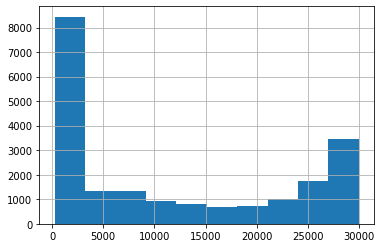

In [26]:
long_labels_df['duration'].hist()

In [27]:
elicitation_wavs = glob('data/elicitation-wavs/wav/*')
elicitation_eafs = glob('data/elicitation-wavs/autotranscribed/*.eaf')

In [28]:
filestem_to_paths = {}
for wav in elicitation_wavs:
    filestem = os.path.splitext(os.path.basename(wav))[0]
    filestem_to_paths[filestem] = {'wav': wav} 


In [29]:
get_wav_with_filestem = lambda fs: filestem_to_paths[fs]['wav']
get_eaf_with_filestem = lambda fs: filestem_to_paths[fs]['eaf']
long_labels_df['wav_source'] = long_labels_df['filestem'].apply(get_wav_with_filestem)

In [30]:
# long_labels_df.to_csv('data/elicitation-wavs/long_labels.csv', index=False)

# Long labels HF dataset
Make a new folder, save `long_labels_df`, snip and move all wavs

In [31]:
'/Users/markjos/projects/malachor5/data/elicitation-wavs/wav'
long_labels_df['wav_source_mac'] = long_labels_df['wav_source'].apply(lambda x: x.replace(
    '/home/AD/mjsimmons/datasets/elicitation-wavs/masked/',
    '/Users/markjos/projects/malachor5/data/elicitation-wavs/wav/'
))
for wav_path in long_labels_df['wav_source_mac'].unique():
    if not os.path.exists(wav_path):
        print(wav_path)

In [32]:
del long_labels_df['wav_source']
long_labels_df = long_labels_df.rename({'wav_source_mac': 'wav_source'}, axis=1)
long_labels_df

,asr_index,start,end,transcription,indices,duration,split,filestem,wav_source
0,11230.0,1229590.0,1259547.0,íŋgánɔ̀nà ɛ́léɲé kə́ náɾùwè nd̪ɔ̀bà T...,"[113180, 69522, 101459, 10, 36988, 69525, 7323...",29957.0,train,HH20220719-2,data/elicitation-wavs/wav/HH20220719-2.wav
1,14569.0,902320.0,930910.0,weird tone patterns. And so that might either ...,"[42, 116519]",28590.0,train,HH20230414-Zoom-3,data/elicitation-wavs/wav/HH20230414-Zoom-3.wav
2,14538.0,1318720.0,1344900.0,"làdɔ́ŋnɛ̀ nìðìnɔ́ŋù ùnɛ̀ɾɛ̀ So actually, ...","[116488, 59]",26180.0,train,HH20220629-2,data/elicitation-wavs/wav/HH20220629-2.wav
3,12250.0,3154322.0,3184300.0,"from the Karcha, Karcha is actually far away. ...","[31526, 72251, 64, 49843, 37711, 19284, 70756,...",29978.0,train,HH20221127,data/elicitation-wavs/wav/HH20221127.wav
4,6154.0,1148379.0,1177450.0,"íŋgáðə́rɔ̀ðà You know, our friend, El Yasse...","[108104, 86, 9008, 63666, 48904]",29071.0,train,HH07242020-Zoom2,data/elicitation-wavs/wav/HH07242020-Zoom2.wav
...,...,...,...,...,...,...,...,...,...
20475,20470.0,1256526.0,1257592.0,ŋàmɽárè,[122420],1066.0,test,HH08212020-2,data/elicitation-wavs/wav/HH08212020-2.wav
20476,20471.0,1261946.0,1262962.0,ŋə̀mìɲàt̪ɔ́ ásá,[122421],1016.0,test,HH20211207-Zoom,data/elicitation-wavs/wav/HH20211207-Zoom.wav
20477,20475.0,1005320.0,1007400.0,ðá nɛ́lê və̀lɛ̀ðɔ́ nd̪ɔ̀bà,[122425],2080.0,train,HH20230516,data/elicitation-wavs/wav/HH20230516.wav
20478,20477.0,1121405.0,1122391.0,ŋə̀búrŋɛ̀ ánó,[122427],986.0,train,HH20230626,data/elicitation-wavs/wav/HH20230626.wav


In [33]:

long_labels_path = 'data/elicitation-wavs/autotranscribed/longlabels.csv'
# long_labels_df.to_csv(long_labels_path, index=False)

In [34]:
long_labels_df = pd.read_csv(long_labels_path)
long_labels_df['transcription'].str.len().describe()

count    20480.000000
mean        97.360791
std         89.925078
min          3.000000
25%         27.000000
50%         55.000000
75%        156.000000
max        540.000000
Name: transcription, dtype: float64

In [35]:
not_eval = long_labels_df['filestem']!='HH20210312'

In [36]:
long_labels_df.columns

Index(['asr_index', 'start', 'end', 'transcription', 'indices', 'duration',
       'split', 'filestem', 'wav_source'],
      dtype='object')

In [37]:
print(f"total\t{(long_labels_df.loc[not_eval,'duration']/3_600_000).sum():.3f} hours")
(long_labels_df.loc[not_eval,'duration']/1_000).describe()

total	67.947 hours


count    20250.000000
mean        12.079518
std         10.931928
min          0.240000
25%          1.959250
50%          7.393000
75%         24.430250
max         29.998000
Name: duration, dtype: float64

In [38]:
asr_df=asr_df.sort_values('asr_index')
asr_df['filestem']=asr_df['eaf_path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
long_labels_df=long_labels_df.sort_values('asr_index')

long_labels_df.loc[asr_df['filestem']=='HH20210312', 'start']=asr_df.loc[asr_df['filestem']=='HH20210312', 'start']
long_labels_df.loc[asr_df['filestem']=='HH20210312', 'end']=asr_df.loc[asr_df['filestem']=='HH20210312', 'end']
long_labels_df['duration']=long_labels_df['end']-long_labels_df['start']

is_train = long_labels_df['split']=='train'
print(f"total\t{(long_labels_df.loc[is_train,'duration']/3_600_000).sum():.3f} hours")
(long_labels_df.loc[is_train,'duration']/1_000).describe()

total	51.752 hours


count    16384.000000
mean        11.371341
std         10.710856
min          0.536000
25%          1.950000
50%          6.149500
75%         23.052000
max         29.998000
Name: duration, dtype: float64

In [66]:
print(asr_df.loc[asr_df['split']=='train', 'transcription'].str.split().apply(len).sum())
asr_df.loc[asr_df['split']=='train', 'transcription'].str.split().apply(len).describe()

53923


count    16384.000000
mean         3.291199
std          1.244452
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         10.000000
Name: transcription, dtype: float64

In [62]:
def add_words_by_lang(s: str, words_by_lang, word_counts_by_lang):
    for w in s.split():
        words_by_lang[get_word_language(w)].add(w)
        word_counts_by_lang[get_word_language(w)]+=1
word_counts_dict ={}
for split in ['train', 'validation', 'test']:
    print(split)
    words_by_lang = {'tira': set(), 'eng': set(), 'misc': set()}
    word_counts_by_lang = {'tira': 0, 'eng': 0, 'misc': 0}
    long_labels_df.loc[long_labels_df['split']==split, 'transcription'].apply(lambda s: add_words_by_lang(s, words_by_lang, word_counts_by_lang))
    word_counts_dict[split]=(word_counts_by_lang, words_by_lang)
    total_words=sum(v for v in word_counts_by_lang.values())
    print(f"tira pct: {word_counts_by_lang['tira']/total_words}")
    print(f"eng pct: {word_counts_by_lang['eng']/total_words}")
    print(f"misc pct: {word_counts_by_lang['misc']/total_words}")

train
tira pct: 0.20980118393966649
eng pct: 0.7374483955096096
misc pct: 0.052750420550723875
validation
tira pct: 0.1478952520802741
eng pct: 0.7918257464512971
misc pct: 0.06027900146842878
test
tira pct: 0.07948278694295167
eng pct: 0.8645014432215521
misc pct: 0.05601576983549621


In [64]:
word_counts_dict['train'][0]

{'tira': 55749, 'eng': 195957, 'misc': 14017}

In [68]:
(55749-54923)/349196

0.0023654337392180896

In [42]:
print(word_counts_by_lang)
words_by_lang['misc']

{'tira': 65179, 'eng': 265150, 'misc': 18867}


{'Chumna.',
 'Durotani',
 'darja',
 'coucou.',
 'Lato,',
 'Valais?',
 'italian',
 'Galando.',
 'kukungapitito.',
 'Kitcheno,',
 'Malden.',
 'Leker',
 'Dhawanaksha',
 'poto,',
 'ngiyol',
 'Ngaal.',
 'karlen',
 'case-mart.com.',
 'Kukulu',
 'vr',
 'Shor.',
 'kota.',
 'Paule',
 "N'kaabh.",
 '98.',
 'Hamid?',
 'Otono.',
 'low-low.',
 'YAML.',
 'ngui',
 'NAPTO,',
 'ezo.',
 'Lali?',
 "n'ele",
 'Lai',
 'Dorna,',
 'Loa',
 'Kupu',
 'P-O-N.',
 'pri...',
 "Kayla's",
 'ver',
 'ngamu',
 'kai',
 'Intira.',
 'Linga,',
 'monto',
 "d'ova",
 'Kamaishi,',
 'Lai?',
 'Arganna.',
 'vala...',
 'Karki',
 'Runlock',
 'kukunga,',
 'not-that-many',
 'au.',
 'Kahino',
 'buddhade.',
 'loado.',
 "po'luli,",
 'Kirlene,',
 'K-O-N.',
 'post-normal',
 'ngau.',
 'chee',
 'toileta',
 'ssawe.',
 'nā',
 'Odenina,',
 "Wendy's.",
 'nyo,',
 'Kakaar,',
 'kāpā',
 'vahara,',
 'Ngave',
 'Sleipnir.',
 'ña,',
 'ZQ.',
 'una.',
 'boli.',
 'kukush',
 'Kiyomo',
 'chafdh',
 'Laori',
 'Ooley,',
 'ndavo.',
 'kongapote,',
 'Kōkongo.',
 'La